# Interpolation (Version 2)

In [1]:
import pandas as pd
import altair as alt

# set altair to fallback to rendering png
alt.renderers.enable('mimetype');

## Load Data

In [2]:
# load data from csv
irradiance_df = pd.read_csv("data/irradiance.csv")

In [3]:
# show first five rows
irradiance_df.head()

,device_id,timestamp,irradiance
0,9,2024-06-01 00:00:00,0
1,9,2024-06-01 01:00:00,0
2,9,2024-06-01 02:00:00,0
3,9,2024-06-01 03:00:00,0
4,9,2024-06-01 04:00:00,0


## Reshape data

In [4]:
# make a copy
df = irradiance_df.copy()

# ensure proper data type
df['timestamp'] =  pd.to_datetime(df['timestamp'])

# ensure we just have a single device, then drop device column
df[df['device_id'] == 9]
df = df[['timestamp', 'irradiance']]

# set index to timestamp and sort index
df = df.set_index('timestamp').sort_index()

# resample so we have one entry for every hour
df_hourly = df.resample('1h').asfreq()

# add column to indicate if data was missing
df_hourly['missing'] = df_hourly['irradiance'].isna()

In [5]:
# preview some rows
df_hourly.iloc[35:40]

,irradiance,missing
timestamp,,
2024-06-02 11:00:00,NaN,True
2024-06-02 12:00:00,NaN,True
2024-06-02 13:00:00,964.0,False
2024-06-02 14:00:00,851.0,False
2024-06-02 15:00:00,NaN,True


## Fill Missing Values

### Part 1: Create average day

In [6]:
# Extract hour component
df_hourly['hour'] = df_hourly.index.hour

In [7]:
# get an average day based on the three existing days
avg_df = (df_hourly[['irradiance']]
          .groupby(df_hourly['hour']).mean('irradiance'))

# preview
avg_df

,irradiance
hour,
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
6,0.000000
7,133.666667
8,381.666667


In [8]:
# convert average values to dictionary
avg_by_hour = avg_df.to_dict()['irradiance']

# create new column
df_hourly['irradiance_avg'] = df_hourly['irradiance']

# fill column using dictionary mapping
df_hourly['irradiance_avg'] = (df_hourly['irradiance_avg']
                               .fillna(df_hourly['hour'].map(avg_by_hour)))

In [9]:
# sample rows 35-40
df_hourly.iloc[35:40]

,irradiance,missing,hour,irradiance_avg
timestamp,,,,
2024-06-02 11:00:00,NaN,True,11,971.0
2024-06-02 12:00:00,NaN,True,12,988.5
2024-06-02 13:00:00,964.0,False,13,964.0
2024-06-02 14:00:00,851.0,False,14,851.0
2024-06-02 15:00:00,NaN,True,15,675.0


### Part 2: Interpolate Missing Values

Fill missing values by using the values before and after

In [10]:
# create new column using interpolation function
df_hourly['irradiance_interpolated'] = df_hourly['irradiance'].interpolate(method='time')

In [11]:
# preview
df_hourly.iloc[35:40]

,irradiance,missing,hour,irradiance_avg,irradiance_interpolated
timestamp,,,,,
2024-06-02 11:00:00,NaN,True,11,971.0,857.50
2024-06-02 12:00:00,NaN,True,12,988.5,910.75
2024-06-02 13:00:00,964.0,False,13,964.0,964.00
2024-06-02 14:00:00,851.0,False,14,851.0,851.00
2024-06-02 15:00:00,NaN,True,15,675.0,703.00


### Part 3: Create average of the two methods

Take the average of the average day and the interpolated value

In [12]:
# take the mean of the two columns
df_hourly['irradiance_fill'] = (df_hourly[['irradiance_avg', 'irradiance_interpolated']]
                                .mean(axis=1))

# fill na using the new column
df_hourly['irradiance'] = df_hourly['irradiance'].fillna(df_hourly['irradiance_fill'])

# select just the cols of interest
# df_hourly = df_hourly[['irradiance', 'missing']]

# preview
df_hourly.iloc[35:40]

,irradiance,missing,hour,irradiance_avg,irradiance_interpolated,irradiance_fill
timestamp,,,,,,
2024-06-02 11:00:00,914.250,True,11,971.0,857.50,914.250
2024-06-02 12:00:00,949.625,True,12,988.5,910.75,949.625
2024-06-02 13:00:00,964.000,False,13,964.0,964.00,964.000
2024-06-02 14:00:00,851.000,False,14,851.0,851.00,851.000
2024-06-02 15:00:00,689.000,True,15,675.0,703.00,689.000


## Make plots

In [13]:
# select just the cols of interest and reset index
data = df_hourly[['irradiance', 'missing']].reset_index()

# preview
data.iloc[35:40]

,timestamp,irradiance,missing
35,2024-06-02 11:00:00,914.250,True
36,2024-06-02 12:00:00,949.625,True
37,2024-06-02 13:00:00,964.000,False
38,2024-06-02 14:00:00,851.000,False
39,2024-06-02 15:00:00,689.000,True


### Quick plot

Lines and points combined, showing which values were interpolated

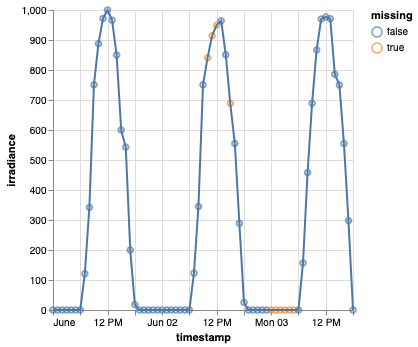

In [14]:
line = alt.Chart(data).mark_line().encode(
    x='timestamp:T',
    y='irradiance:Q',
)

points = alt.Chart(data).mark_point().encode(
    x='timestamp:T',
    y='irradiance:Q',
    color="missing:N",
)

points + line

#### Fancy plot

Bar chart with more styling

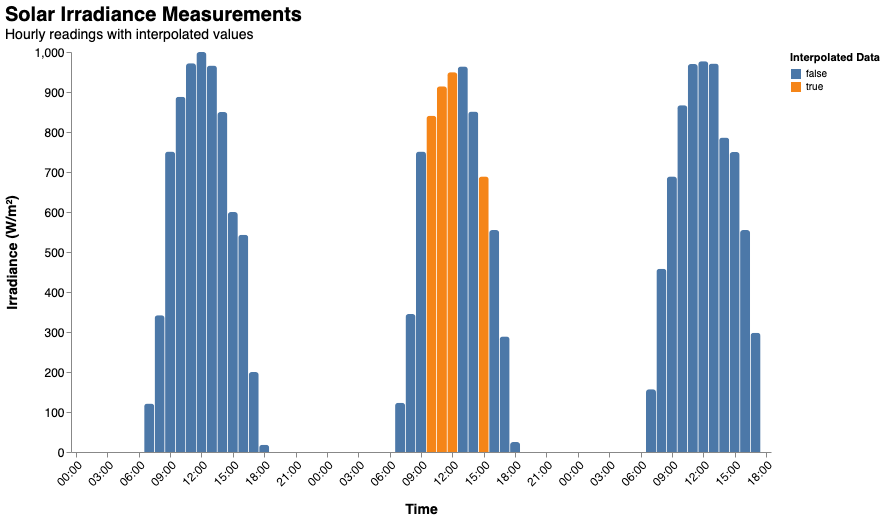

In [15]:
alt.Chart(data).mark_bar(
    cornerRadiusTopLeft=3, cornerRadiusTopRight=3, width=10
).encode(
    x=alt.X(
        "timestamp:T",
        title="Time",
        axis=alt.Axis(labelAngle=-45, format="%H:%M", grid=False),
    ),
    y=alt.Y("irradiance:Q", title="Irradiance (W/m²)"),
    color=alt.Color(
        "missing:N",
        legend=alt.Legend(title="Interpolated Data"),
    ),
).properties(
    width=700,
    height=400,
    title={
        "text": "Solar Irradiance Measurements",
        "subtitle": "Hourly readings with interpolated values",
        "fontSize": 20,
        "subtitleFontSize": 14,
        "anchor": "start",
    },
).configure_view(
    strokeWidth=0
).configure_axis(
    labelFontSize=12, titleFontSize=14, titlePadding=15, grid=False
).configure_title(
    fontSize=20
)

### Sum irradiance

Sum the irradiance values for each day

In [16]:
daily_sums = data.set_index('timestamp').resample('D')['irradiance'].sum()
pd.DataFrame(daily_sums)

,irradiance
timestamp,
2024-06-01,7251.00
2024-06-02,7296.75
2024-06-03,7478.00
